https://www.youtube.com/watch?v=wqQKFu41FIw&ab_channel=CodingTech

https://www.youtube.com/watch?v=v5ijNXvlC5A&ab_channel=Enthought

https://www.youtube.com/watch?v=kAI67Sz92-s&list=PL-bdv-10yhrPGf9mNzQJvTc3yhhwpfOAz&index=1&ab_channel=AbhishekThakur

# Introduction

A **time series** is a time-oriented or chronological sequence of observations on a variable of interest. (Formally, a time series is a collection of random variables ordered according to the time instant at which they are collected: $\{y_1, y_2, ...\}$, where $y_i$ denotes the value of the random variable at time $i$. Therefore, a time series is a realization of a stochastic process $\{y_t\}$, $t=1,2,...$). 


**Forecasting vs Supervised regression**

A common mistake is to treat a time series analysis problem as a supervised regression problem. Both are intended to predict numbers, but they are not the same type of problem: 
- In supervised regression, we predict label/target variables from feature variables, in a cross-sectional set-up. This is after training on label/feature random samples of independent observations. 
- In forecasting, we predict future values from past values, of the same variable, in a temporal/sequential set-up. This is after training on the past.

<span style="color:grey"> The detailed exposition can be found in [The pitfalls of mis-diagnosing forecasting as supervised regression](https://github.com/alan-turing-institute/sktime/blob/main/examples/01a_forecasting_sklearn.ipynb)).</span>

In fact, the main characteristic of a time series is that consecutive observations are **not** usually independent, but are correlated and it is necessary to take into account the time **order** in the analysis.

#TODO: describe contents of the notebook

### Package imports

In [59]:
# data handling
import pandas as pd
import numpy as np

# time series handling
from sktime.datasets import load_airline

# visualization
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Time series examples

1. **Economic time series**

Examples of economic time series include share prices on successive days, average incomes in successive months, company profits in succesive years, etc. 

Below is the classic Beveridge wheat price index series, which represents the average wheat price of almost 50 different locations from the year 1500 to 1869.

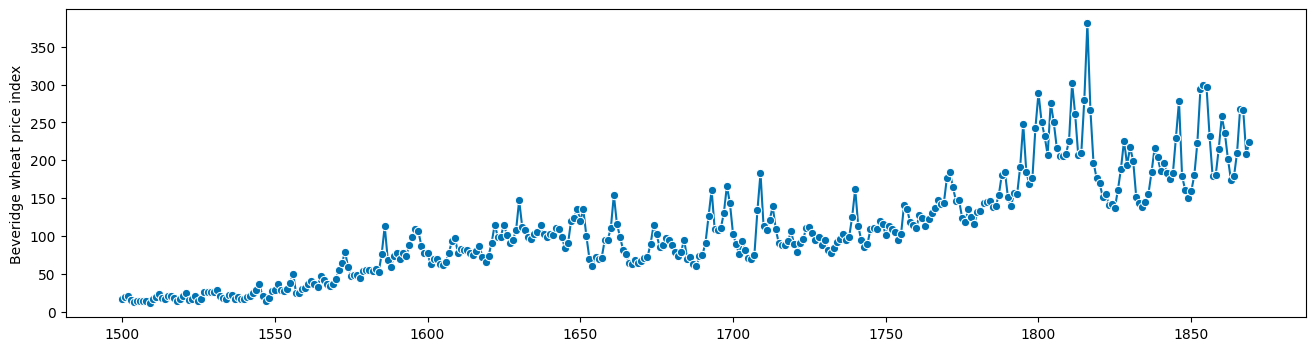

In [60]:
beveridge = pd.read_csv('..\data\\beveridge.csv', index_col=0)
beveridge = pd.Series(beveridge['Beveridge wheat price index'])
plot_series(beveridge) # plot series
plt.show()

2. **Physical time series**

Some time series are generated by physical processes, such as meteorological or geophysical phenomena. Examples are rainfall on successive days, air temperature measured in successive hours, days or months. 

The figure below shows deviations of global mean land-ocean temperature index from 1880 to 2009 from the 1951-1980 temperature average. There has been an upward trend since the end of the 20th century, which has been used as an argument in favor of climate change. 

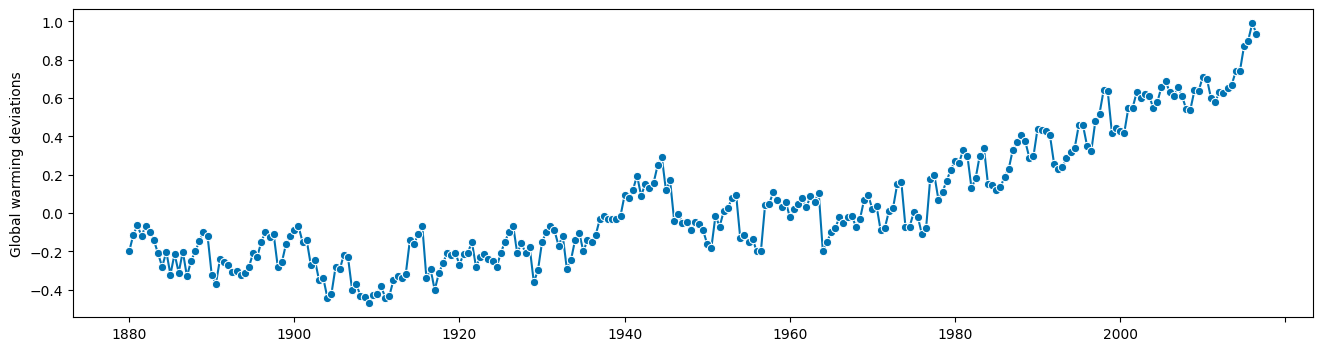

In [61]:
global_warming = pd.read_csv('..\data\\global_warming_deviations.csv', index_col=0)
global_warming = pd.Series(global_warming['Global warming deviations'])
plot_series(global_warming)
plt.show()

3. **Marketing time series**

A problem of interest in commerce is the analysis of sales in successive days, weeks or months. Knowing past sales can help to forecast or estimate the number of future sales to prepare the warehouse or prepare budgets.

The time series below corresponds to the sales volumes of anti-diabetic drugs in Australia, collected by month. The data were used to forecast the annual budget for the Pharmaceutical Benefit Scheme (PBS) by the Australian Government.

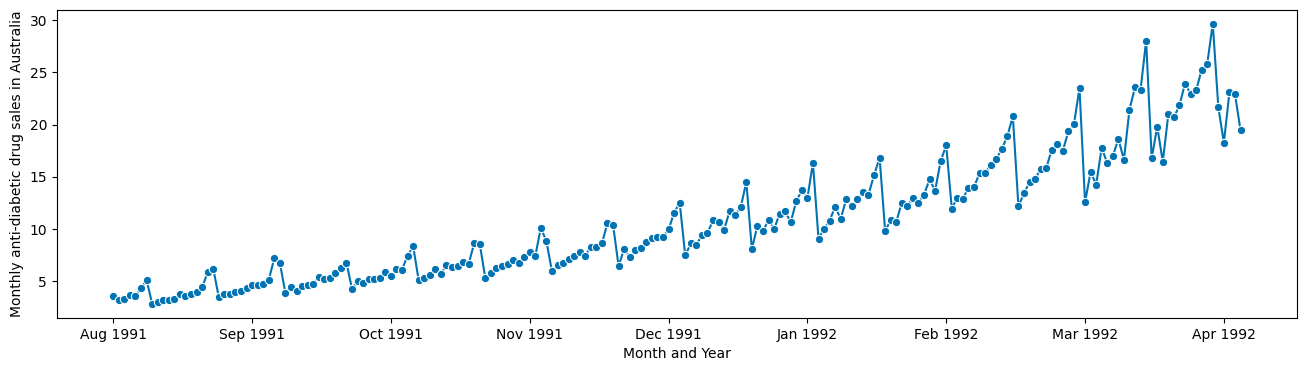

In [62]:
antidiabetic_sales = pd.read_csv('..\data\Monthly_anti-diabetic_drug_sales_in_Australia_from_1991_to_2008.csv', index_col=0, parse_dates=['Date'])
antidiabetic_sales = pd.Series(antidiabetic_sales['Monthly anti-diabetic drug sales in Australia'])
fig, ax = plot_series(antidiabetic_sales)
ax.set_xticklabels(antidiabetic_sales.index.strftime('%b %Y'))
ax.set_xlabel('Month and Year')
plt.show()

----------------------------------------------------------------


# Important concepts 
## Univariate or Multivariate time series

The previous series were examples of **univariate** series, the simplest form of time series. Sometimes it is more convenient to add information from predictors related to the output variable to better describe or predict it. This is known as **multivariate** time series and an example is shown below.

**Multivariate US consumption expenditure series**

If you want to predict US consumption expenditure, you can use quarterly percentage changes in industrial production and personal savings as well as the unemployment rate, which may be related to the first one.

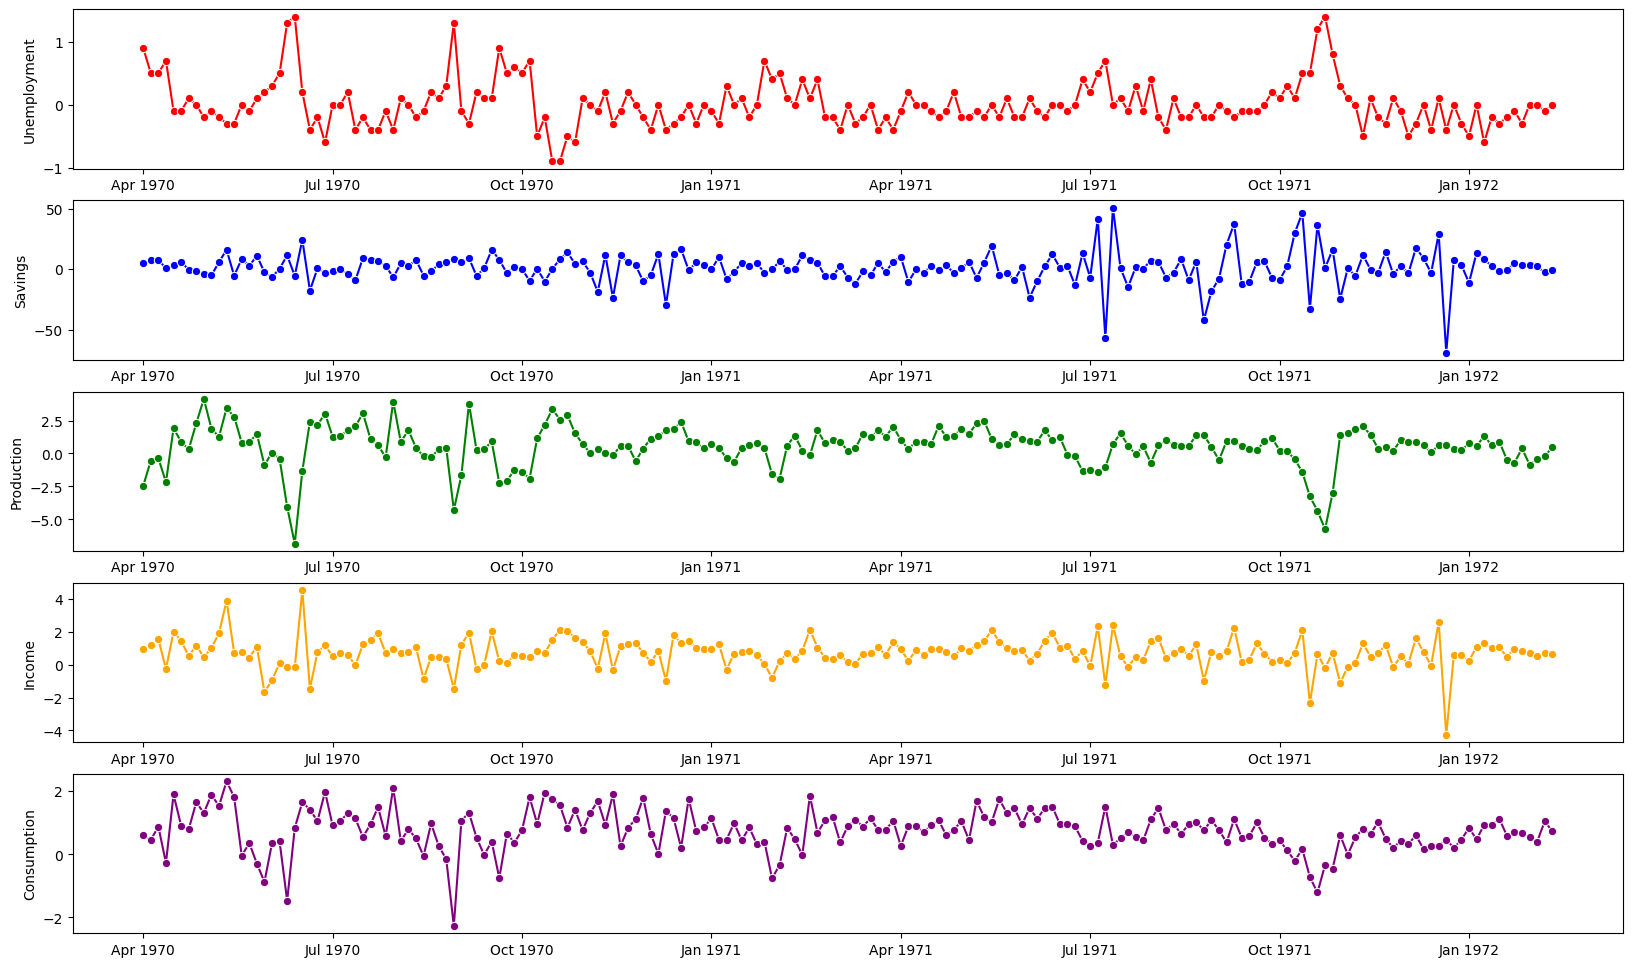

In [104]:
uschange = pd.read_csv('..\data\\uschange.csv', index_col=['Date'])

fig, ax = plt.subplots(5, 1, figsize=(20, 12)) # define figure with subplots
colors = ['red', 'blue', 'green', 'orange', 'purple'] # define list of colors

# decompose the multivariate series into univariate series and plot them
for variable in uschange.columns:
    uschange[variable] = pd.Series(uschange[variable])
    uschange[variable].index = pd.to_datetime(uschange[variable].index)
    # plot the series in the same figure with same format as above figures in subplot
    plot_series(uschange[variable], ax=ax[uschange.columns[::-1].get_loc(variable)])

# change color of each subplot line
for i in range(5):
    ax[i].lines[0].set_color(colors[i]) 
    # set xticklabels to be month and year
    ax[i].set_xticklabels(pd.to_datetime(uschange.index).strftime('%b %Y'))
   
plt.show()


## Terminology

- A time series is said to be **continuous** when observations are made continuously in time; and is **discrete** when observations are taken only at specific times, usually equally spaced. A continuous time series can be transformed to a discrete time series by taking its values ar equal intervals of time (**sampled** series) or by **aggregating** (accumulating) the values over equal intervals of time.

- When successive observations are dependent, future values may be predicted from the past ones. If a time series can be predicted exactly (in a closed form by means of a mathematical expression), it is said to be **deterministic** (unfortunately, this is not usually the case). Most time series are **stochastic**: the future is only partially determined by past values, so it is impossible to provide accurate predictions and must be replaced by the idea that future values follow a probability distribution conditional on knowledge of past values. 

-------------------------------------------------

# Objectives of time series analysis

The first step in a time series analysis is to define the problem to be solved. This includes stating what the objective of the analysis is and what it is intended to solve.

1. **Description:** The first step of a time series analysis is to **plot** the series and find its main characteristics: **trend, seasonal patterns, outliers**. Outliers (values that do not appear to be consistent with the rest of the observations) may simply be extreme values that indicate that the distribution of the data is not normal; or they may be measurement errors, in which case they should be adjusted before any analysis.
This identification phase can help to decide whether the variation of a time series can be well represented by the combination of simple patterns or whether a more complex model is needed.

2. **Explanation:** When two or more variables are observed, it may be possible to use the variation in one time series to **explain the variation** in another. This could lead to a better **understanding** of the mechanism that produced a given time series. The application of explainable methods or models, such as multiple regression, is essential: if the objective is to explain the relationship between time series, models such as neural networks are ruled out. For example, it may be of interest to study how sales are affected by price and economic conditions.

3. **Forecast:**  Given an observed time series, one may want to predict the future values of the series. Predicting certain things is simpler than others. Tomorrow morning's sunrise timing can be predicted with accuracy. The lottery numbers for tomorrow, however, cannot be predicted with any degree of accuracy. The degree to which an event or amount is predictable relies on a number of variables, including: 
    - how effectively we comprehend the contributing components; 
    - the amount of data that is obtainable; 
    - and whether or not the forecasts can influence the thing that we are seeking to forecast

4. **Control:** The goal of the analysis may be to control the process when a time series is created to gauge the effectiveness of a manufacturing process. In order to keep the process on track, a stochastic model is fitted to the series, future values of the series are predicted, and the input process variables are adjusted so as to keep the process on target.

-----------------------------------

# Simple descriptive techniques

# Data: Air passegenger bookings

To ilustrate

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

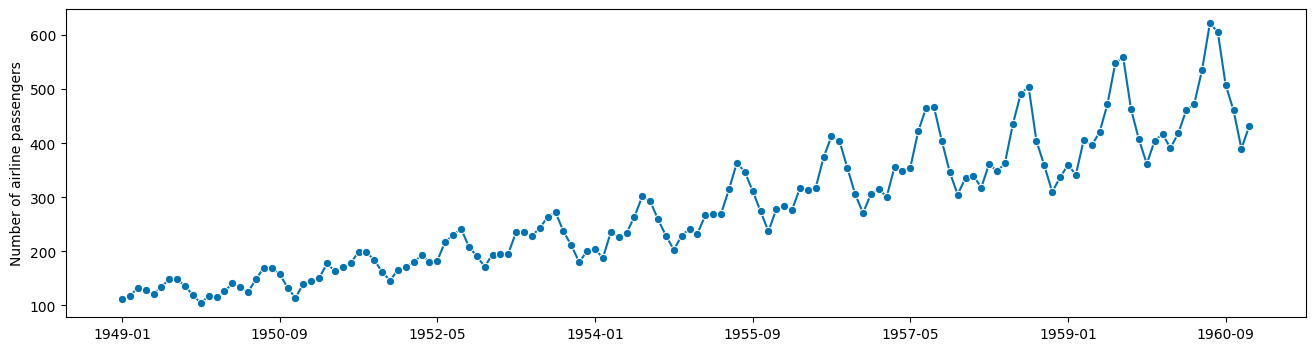

In [9]:
y = load_airline()
plot_series(y)